In [1]:
# import required libraries
import pandas as pd
import numpy as np
import shutil
import os
from PIL import Image
import re
import random
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.utils       import resample


from io import BytesIO
from zipfile import ZipFile

# Loading the scrapped data from DermNet.


In [2]:
# load and preview dataset
image_df = pd.read_csv('../data/data1-294.csv')
print(image_df.shape)
image_df.head()

(13992, 2)


,skin_disorder_name,images
0,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
1,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
2,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
3,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
4,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...


# Find any duplicates

In [3]:
print('there are {} duplicate records'.format(len(image_df['images'][image_df['images'].duplicated()])))

there are 4413 duplicate records


In [4]:
sample_dup_img = image_df['images'][image_df['images'].duplicated()][1148]
image_df[image_df['images'] == sample_dup_img]

,skin_disorder_name,images
1059,atopic dermatitis images,https://dermnetnz.org/assets/collection/Atopic...
1148,atopic eczema images,https://dermnetnz.org/assets/collection/Atopic...
2447,besnier prurigo images,https://dermnetnz.org/assets/collection/Atopic...
3415,dermatitis images,https://dermnetnz.org/assets/collection/Atopic...


In [60]:
ls ../data/image/dup_image/

ArsenicSkinImageBD.zip        eczema.zip
ISIC_2019_Training_Input.zip  keratosis.zip
ISIC_2020_Training_JPEG.zip   melanoma.zip
acne/                         psoriasis.zip
acne.zip                      tinea.zip
dup_image/


In [64]:

# os.path.isdir('../data/image/dup_image/')
for url in image_df[image_df['images'].duplicated()]['images']:
    pic_name = url.split('/')[-1]
    img_data = requests.get(url).content
    with open(f'../data/image/dup_image/{pic_name}', 'wb') as handler:
        handler.write(img_data)
print(f'all dup images loaded')

all dup images loaded


,skin_disorder_name,images
1269,atypical melanocytic naevus,https://dermnetnz.org/assets/Uploads/lesions/a...
1311,atypical naevus images,https://dermnetnz.org/assets/Uploads/lesions/a...
1414,b-k mole images,https://dermnetnz.org/assets/Uploads/lesions/a...
2824,clark nevus images,https://dermnetnz.org/assets/Uploads/lesions/a...
4198,dysplastic naevi images,https://dermnetnz.org/assets/Uploads/lesions/a...


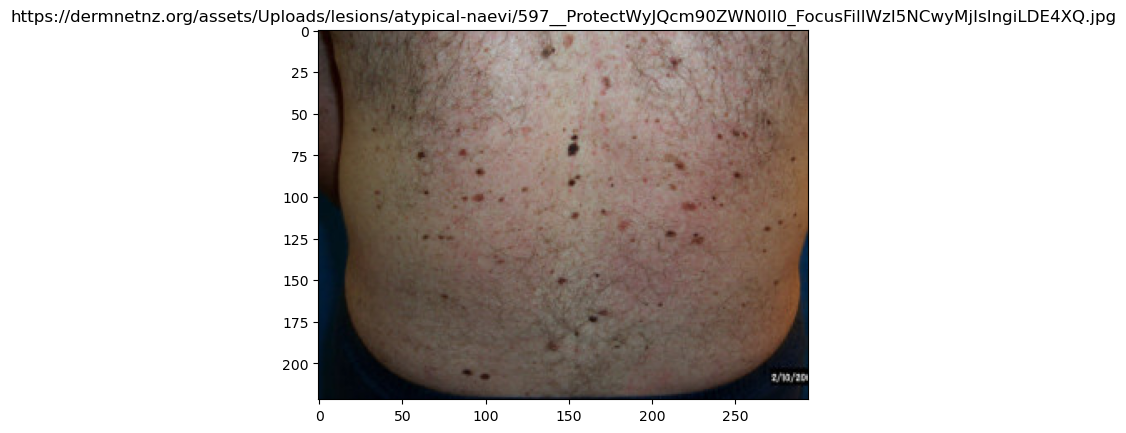

In [5]:
image_index = random.choice(image_df[image_df['images'].duplicated()]['images'].reset_index(drop=True))
img = cv2.imread('../data/image/dup_image/'+image_index.split('/')[-1])[...,[2,1,0]]
plt.title(image_index)
plt.imshow(img)


sample_dup_img = image_df['images'][image_df['images'] == image_index]

image_df[image_df.index.isin(sample_dup_img.index.to_list())]

# drop dups

In [6]:
dup_img_idx = image_df['images'][image_df['images'].duplicated()].index.to_list()
image_df_drop_dups = image_df[~image_df.index.isin(dup_img_idx)]
image_df_drop_dups.shape

(9579, 2)

In [7]:
image_df_drop_dups.head()

,skin_disorder_name,images
0,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
1,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
2,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
3,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...
4,acne affecting the back images,https://dermnetnz.org/assets/Uploads/acne/acne...


# create a column for image name 

In [8]:
image_df['image_name'] = image_df['images'].apply(lambda x: x.split('/')[-1])
image_df['image_name']

0        141__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...
1        142__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...
2        143__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...
3        144__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...
4        146__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyM...
                               ...                        
13987    xeroderma-pigmentosum-13__ProtectWyJQcm90ZWN0I...
13988    xeroderma-pigmentosum-14__ProtectWyJQcm90ZWN0I...
13989    xeroderma-pigmentosum-15__ProtectWyJQcm90ZWN0I...
13990    xeroderma-pigmentosum-16__ProtectWyJQcm90ZWN0I...
13991    xeroderma-pigmentosum-17__ProtectWyJQcm90ZWN0I...
Name: image_name, Length: 13992, dtype: object

# check URL's status

In [9]:
def get_url_status(urls):  # checks status for each url in list urls
    url_status = []
    for url in urls:
        try:
            r = requests.get(url)
            url_status.append(url + "\tStatus: " + str(r.status_code))
        except Exception as e:
            url_status.append(url + "\tNA FAILED TO CONNECT\t" + str(e))
        df = pd.DataFrame(url_status)
        df.rename(columns = {0: 'link'}, inplace = True)
        df[['link', 'status']] = df['link'].str.split('\t', expand=True)
    return df

status_df = get_url_status(image_df_drop_dups['images'].to_list())

In [12]:
status_df

,link,status
0,https://dermnetnz.org/assets/Uploads/acne/acne...,Status: 200
1,https://dermnetnz.org/assets/Uploads/acne/acne...,Status: 200
2,https://dermnetnz.org/assets/Uploads/acne/acne...,Status: 200
3,https://dermnetnz.org/assets/Uploads/acne/acne...,Status: 200
4,https://dermnetnz.org/assets/Uploads/acne/acne...,Status: 200
...,...,...
9574,https://dermnetnz.org/assets/Uploads/xeroderma...,Status: 200
9575,https://dermnetnz.org/assets/Uploads/xeroderma...,Status: 200
9576,https://dermnetnz.org/assets/Uploads/xeroderma...,Status: 200
9577,https://dermnetnz.org/assets/Uploads/xeroderma...,Status: 200


In [11]:
status_df['status'].value_counts()

Status: 200    9558
Status: 404      21
Name: status, dtype: int64

# Remove 21 images that their urls are not not working

In [13]:
url_not_working_list = status_df[status_df['status'] == "Status: 404"]['link'].to_list()

In [14]:
image_cleaned_df = image_df_drop_dups[~image_df_drop_dups['images'].isin(url_not_working_list)]
image_cleaned_df.shape

(9558, 2)